In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/animal-faces")

print("Path to dataset files:", path)

Resuming download from 423624704 bytes (306076051 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/andrewmvd/animal-faces?dataset_version_number=1 (423624704/729700755) bytes left.


100%|██████████| 696M/696M [09:49<00:00, 519kB/s]   

Extracting files...


Path to dataset files: C:\Users\VICTUS\.cache\kagglehub\datasets\andrewmvd\animal-faces\versions\1


In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image 
import pandas as pd
import numpy as np
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device available: ", device)

Device available:  cuda


In [2]:
image_path = []
labels = []


for i in os.listdir('C:/Users/VICTUS/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1/afhq'):
    for label in  os.listdir(f"C:/Users/VICTUS/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1/afhq/{i}"):
        for image in  os.listdir(f"C:/Users/VICTUS/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1/afhq/{i}/{label}"):
            image_path.append(f"C:/Users/VICTUS/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1/afhq/{i}/{label}/{image}")
            labels.append(label)

data_df =pd.DataFrame(zip(image_path,labels),columns = ["image_path","labels"])
print(data_df["labels"].unique())
data_df.head()        
        

['cat' 'dog' 'wild']


,image_path,labels
0,C:/Users/VICTUS/.cache/kagglehub/datasets/andr...,cat
1,C:/Users/VICTUS/.cache/kagglehub/datasets/andr...,cat
2,C:/Users/VICTUS/.cache/kagglehub/datasets/andr...,cat
3,C:/Users/VICTUS/.cache/kagglehub/datasets/andr...,cat
4,C:/Users/VICTUS/.cache/kagglehub/datasets/andr...,cat


In [3]:
train = data_df.sample(frac = 0.7)
test = data_df.drop(train.index)
val = test.sample(frac = 0.5)
test= test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


In [4]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self,dataframe,transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)
    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self,idx):
        img_path = self.dataframe.iloc[idx,0]
        label=self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image).to(device)
        return image,label

In [6]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)

In [7]:
#hyperperameters 
LR =1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [8]:
train_loader = DataLoader(train_dataset , batch_size = BATCH_SIZE,shuffle = True)
test_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE,shuffle = False )
val_loader = DataLoader(val_dataset , batch_size = BATCH_SIZE,shuffle = False )

In [11]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # ✅ Instead of Flatten → Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # output size = (128, 1, 1)

        self.fc = nn.Sequential(
            nn.Flatten(),                   # (batch, 128)
            nn.Dropout(0.5),                # regularization
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, len(data_df["labels"].unique()))     # final output
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = self.gap(x)  # (batch, 128, 1, 1)
        x = self.fc(x)
        return x



In [13]:
model = Net().to(device)

In [14]:
from torchsummary import summary
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
AdaptiveAvgPool2d-13            [-1, 128, 1, 1]               0
          Flatten-14                  [

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=LR)

In [16]:
total_loss_train_plot =[]
total_loss_validation_plot =[]
total_acc_train_plot =[]
total_acc_validation_plot =[]

for epoch in range(EPOCHS):
    total_acc_train =0
    total_loss_train =0
    total_acc_val =0
    total_loss_val =0
    for inputs , labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs,labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        train_acc =(torch.argmax(outputs, axis = 1)== labels).sum().item()

        total_acc_train+= train_acc
        optimizer.step()
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs,labels)
            total_loss_val += val_loss.item()
           
            val_acc =(torch.argmax(outputs, axis = 1)== labels).sum().item()
            total_acc_val+= val_acc
    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_validation_plot.append(round(total_loss_val/1000,4))

    total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
    total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__())*100,4))

    print(f'''Epoch {epoch+1}/{EPOCHS} Train Loss : {round(total_loss_train/1000,4)}  train Accuracy: {round((total_acc_train/train_dataset.__len__())*100,4)}
              Validation Loss : {round(total_loss_val/1000,4)}  Validation Accuracy: {round((total_acc_val/val_dataset.__len__())*100,4)}
    ''')

Epoch 1/25 Train Loss : 0.6468  train Accuracy: 54.6807
              Validation Loss : 0.1294  Validation Accuracy: 59.0909
    
Epoch 2/25 Train Loss : 0.5508  train Accuracy: 63.9979
              Validation Loss : 0.1147  Validation Accuracy: 66.6116
    
Epoch 3/25 Train Loss : 0.4994  train Accuracy: 69.2853
              Validation Loss : 0.1047  Validation Accuracy: 69.9587
    
Epoch 4/25 Train Loss : 0.4677  train Accuracy: 71.9334
              Validation Loss : 0.099  Validation Accuracy: 72.6033
    
Epoch 5/25 Train Loss : 0.4484  train Accuracy: 73.4567
              Validation Loss : 0.0964  Validation Accuracy: 74.2149
    
Epoch 6/25 Train Loss : 0.43  train Accuracy: 74.5461
              Validation Loss : 0.0922  Validation Accuracy: 75.6612
    
Epoch 7/25 Train Loss : 0.4146  train Accuracy: 75.5735
              Validation Loss : 0.0912  Validation Accuracy: 75.5785
    
Epoch 8/25 Train Loss : 0.4055  train Accuracy: 76.034
              Validation Loss : 0.0915

In [17]:
with torch.no_grad():
    total_loss_test=0
    total_acc_test=0
    for inputs,labels in test_loader:
        predictions = model(inputs)

        test_acc =(torch.argmax(predictions, axis = 1)== labels).sum().item()
        total_acc_test+= test_acc
         
        test_loss = criterion(predictions,labels)
        total_loss_test += test_loss.item()
           
        
print(f'Epoch {epoch+1}/{EPOCHS} test Loss : {round(total_loss_test/1000,4)}  test Accuracy: {round((total_acc_test/test_dataset.__len__())*100,4)}')
    

Epoch 25/25 test Loss : 0.2744  test Accuracy: 37.2055


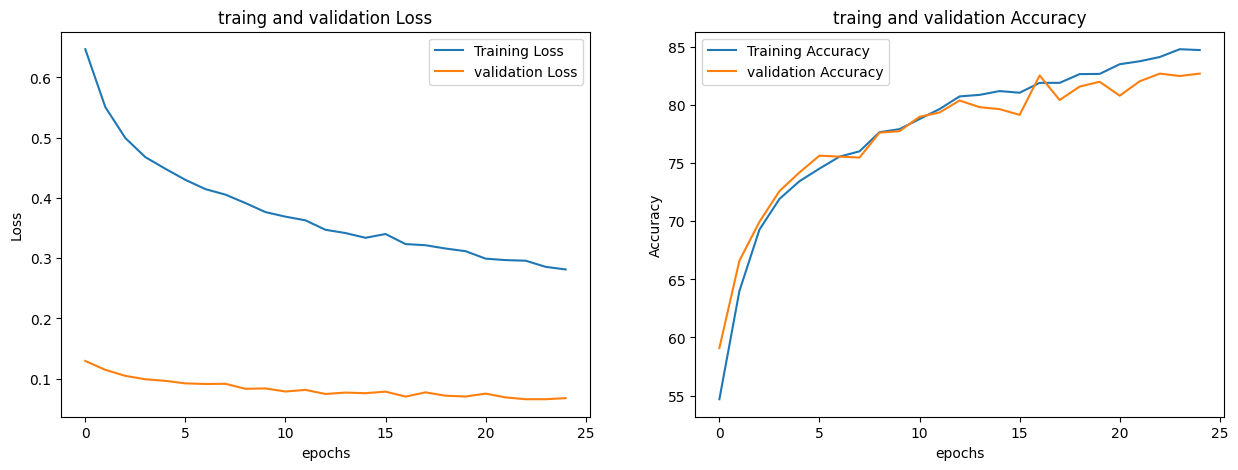

In [18]:
fig,axs =plt.subplots(nrows = 1 , ncols =2 , figsize = (15,5))

axs[0].plot(total_loss_train_plot, label ="Training Loss")
axs[0].plot(total_loss_validation_plot, label ="validation Loss")
axs[0].set_title("traing and validation Loss")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()


axs[1].plot(total_acc_train_plot, label ="Training Accuracy")
axs[1].plot(total_acc_validation_plot, label ="validation Accuracy")
axs[1].set_title("traing and validation Accuracy")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

In [19]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    
    output = model(image.unsqueeze(0))
    output = torch.argmax(output , axis = 1).item()
    return label_encoder.inverse_transform([output])

In [24]:
predict_image("C:/Users/VICTUS/Downloads/15.jpg")

array(['cat'], dtype=object)

In [25]:
# Save only the weights
torch.save(model.state_dict(), "best_model_weights.pth")
print("Model weights saved ✅")


Model weights saved ✅
